# Data Mining and Text Mining Challenge 2020

__Tasio Mendez Ayerbe__ <br>
tasio.mendez (@) mail.polimi.it <br>


# 2 Modeling

In this notebook, several models are evaluated using the data prepared on the [previous notebook](DMTM2020-NB1-Data%20Exploration.ipynb). The performance of the models will be evaluated by means of the __MAPE__ (Mean Absolute Percentage Error) defined as,

$ MAPE = \frac {1}{n} \sum_{i=1}^{n} \left | \frac{A_i - F_i}{A_i} \right | $, where $A_i$ stands for the actual value and $F_i$ for the forecast value.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd

# select the style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 16)
mpl.rcParams['figure.dpi'] = 80

import warnings
warnings.filterwarnings('ignore')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
df = pd.read_csv('./data/train_clean.csv', parse_dates=['date'], index_col=['date'])
df.head()

,sku,size,brand,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single
date,,,,,,,,,,,,
2016-12-17,2689,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0,-0.027053,0.0,1.0
2016-12-24,2689,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0,-0.061477,0.0,1.0
2016-12-31,2689,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0,-0.252911,0.0,1.0
2017-01-07,2689,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0,0.574764,0.0,1.0
2017-01-14,2689,395.41,BRAND1,1.16,0.0,29.058565,25971.0,0,26627.0,0.025259,0.0,1.0


---

## 2.1 Baseline

The baseline algorithm in orther to predict the sales of the next week is a Linear Regression model taking as input the sales of the previous week by scoring it with the Mean Absolute Percentage Error.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score

In [6]:
# Cross-validation 10-fold
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# MAPE function scorer
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [7]:
base = LinearRegression()

X = df[['sales']]
y = df['target']

scores = np.abs(cross_val_score(base, X, y, cv=cv, scoring=scorer))

MAPE Error: 17.0921 (+/- 2.1412)


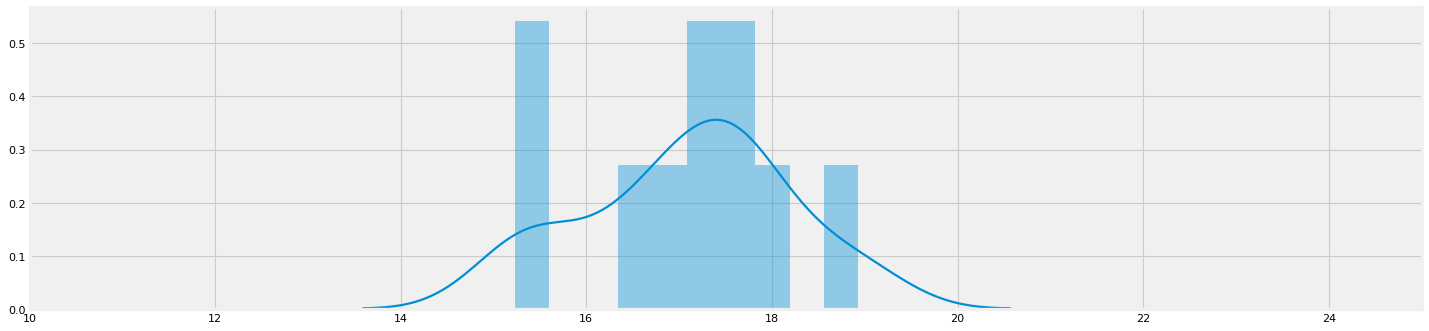

In [8]:
# print("Scores in every iteration", scores)
print("MAPE Error: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

f, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.distplot(scores, bins=10, ax=axes).set_xlim(10,25)
plt.show()

Thus, as it can be shown, the MAPE error for the baseline algorithm is <span style="border: 1px solid green; padding: 0px 5px; border-radius: 10px; margin: 0px 3px;"> 17.0921 </span>. Hence, the idea of the remainder of the notebook is to get an algorithm with a better MAPE result than this one.

---

## 2.2 ARMA Model

The first evaluation will consist on the ARMA, ARMAX and ARIMA models. Since we have one time serie per product, we should create one model per product. However, this is not feasible as we have 43 different products. Thus, a possible approach is to create one model per brand, as products in the same brand seems to have similar behaviors, as it is shown below.

In [9]:
from pmdarima.arima import auto_arima, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

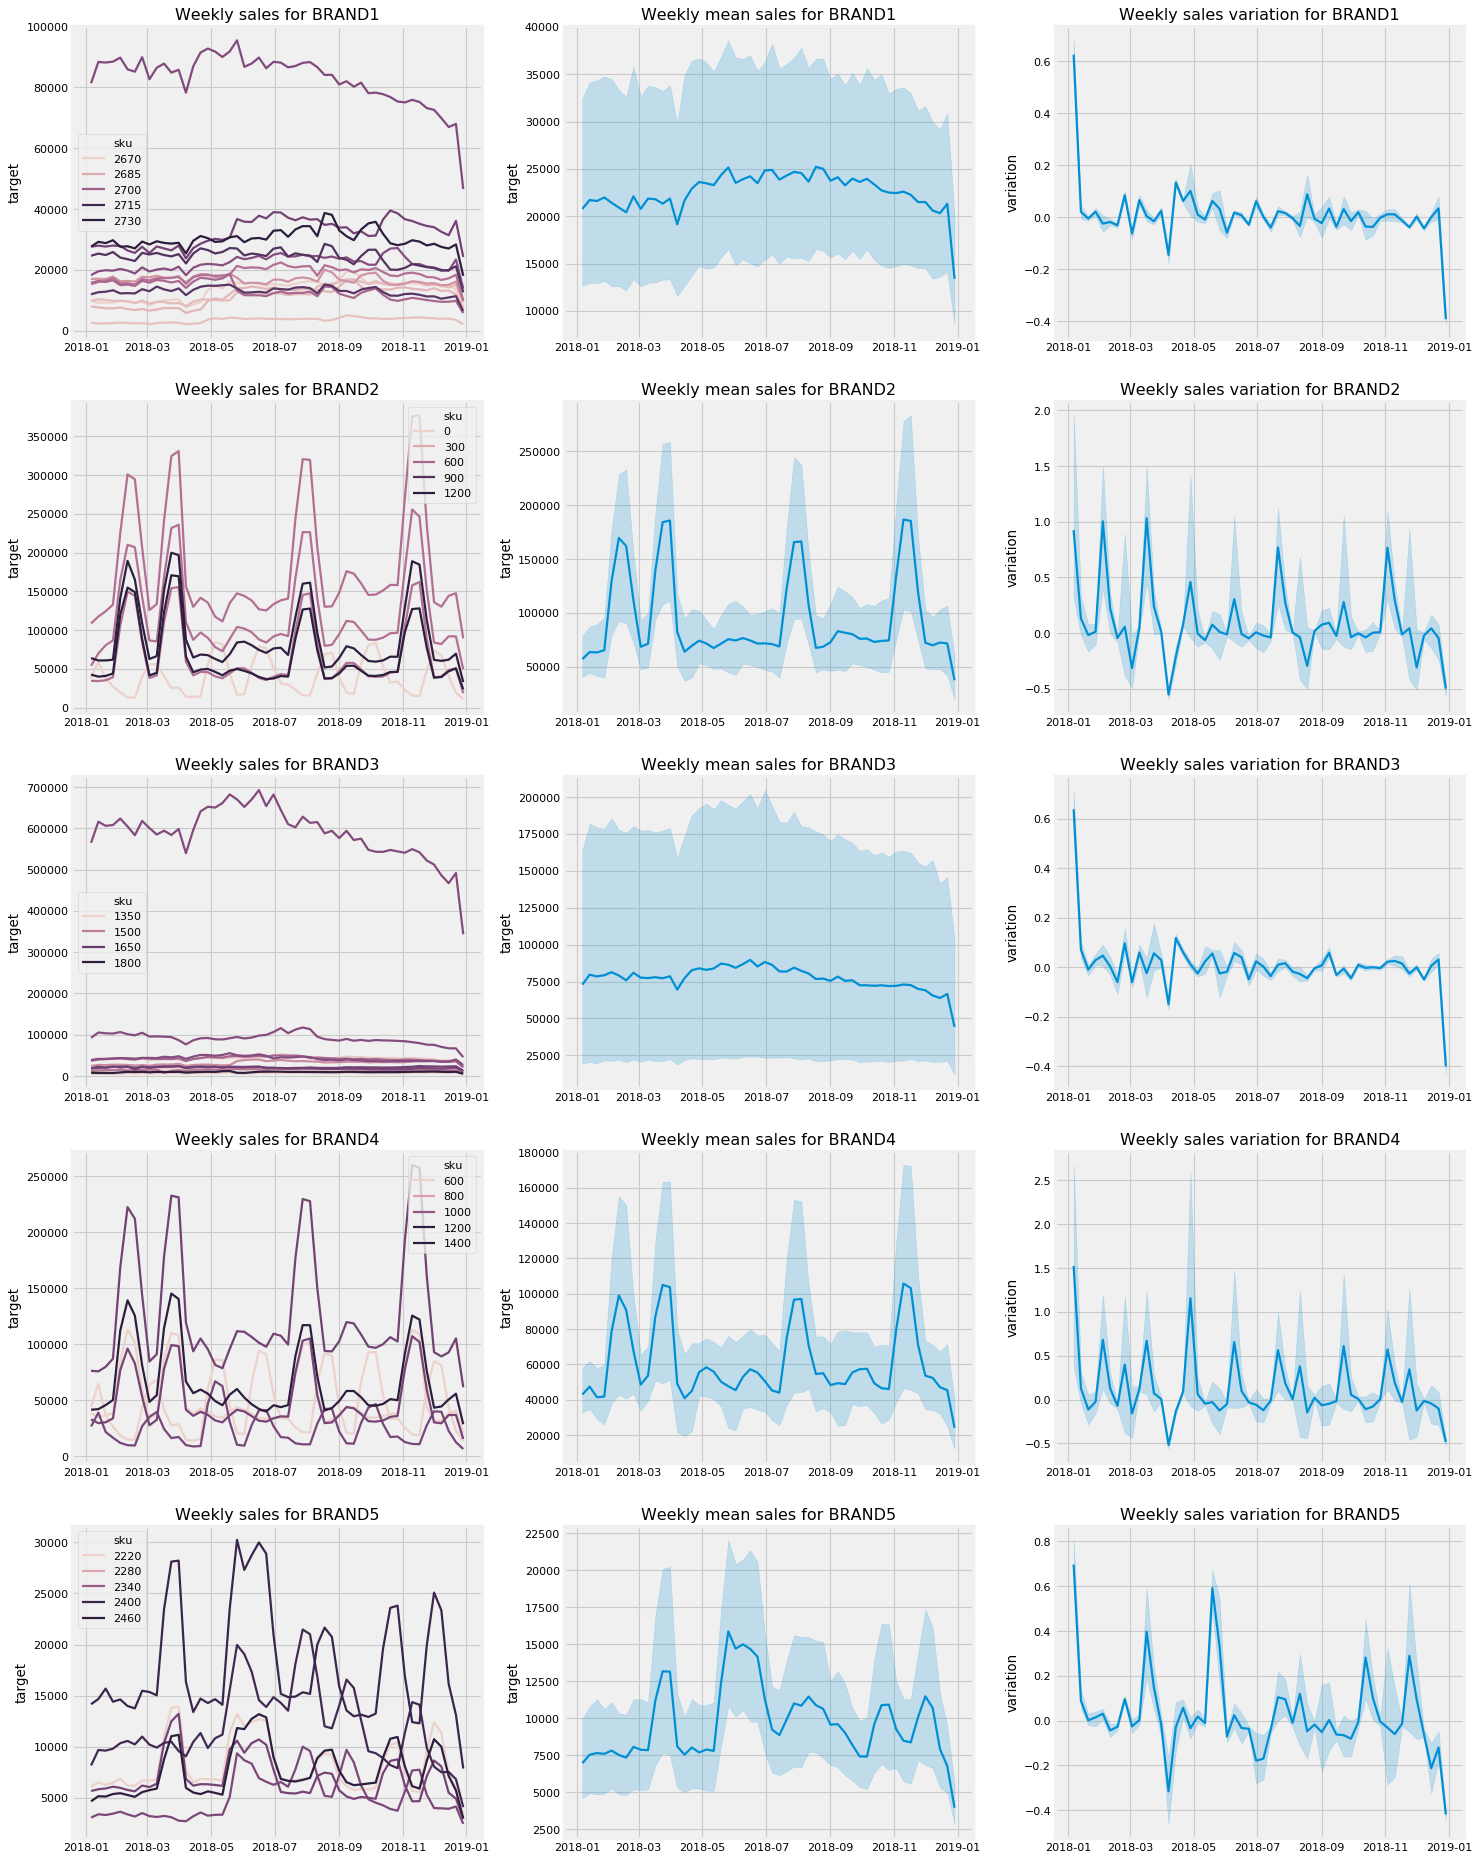

In [10]:
f, axes = plt.subplots(5, 3, figsize=(20, 30))

for brand, index in zip(df.brand.unique(), range(len(df.brand.unique()))):
    data = df[df.brand == brand]['2018']
    x = data.index.get_level_values(0).to_series().values

    sns.lineplot(x=x, y=data.target, hue=data.sku, ax=axes[index][0]).set_title("Weekly sales for {}".format(brand))
    sns.lineplot(x=x, y=data.target, ax=axes[index][1]).set_title("Weekly mean sales for {}".format(brand))
    sns.lineplot(x=x, y=data.variation, ax=axes[index][2]).set_title("Weekly sales variation for {}".format(brand))

We already noted that the weekly sales are non-stationary for some SKUs, so a better approach is using the weekly sales variation at it has been proved that it is stationary. However, when working over the brands, as we are actually working with a mean value, we should work using the variation ratio instead of the sales value, as it is a relative measure.

For this reason, in this section an ARMA model is proposed by optimizing it using a grid search, taking as input variable the weekly sales variation.

In [11]:
p, q, bic, aic, brands, err = [], [], [], [], [], []

for brand in df.brand.unique():
    print('Computing ARMA models for {}'.format(brand))
    data = df[df.brand == brand].groupby(['date', 'brand']).mean()
    for ar_order in range(4):
        for ma_order in range(4):
            # print('ARMA degrees set to ({},{})'.format(ar_order, ma_order))
            model = ARMA(data.variation.iloc[:88], order=(ar_order, ma_order))
            try:
                result = model.fit()
            except:
                continue
            
            p.append(ar_order)
            q.append(ma_order)
            bic.append(result.bic)
            aic.append(result.aic)
            brands.append(brand)
            err.append(mean_absolute_percentage_error(data.variation.iloc[:88].values, result.fittedvalues))
        
gridsearch = pd.DataFrame({'brand':brands,'AR(p)':p,'MA(q)':q,'AIC':aic,'BIC':bic,'MAPE':err})

Computing ARMA models for BRAND1
Computing ARMA models for BRAND2
Computing ARMA models for BRAND3
Computing ARMA models for BRAND4
Computing ARMA models for BRAND5


In [12]:
idx = gridsearch.groupby('brand').AIC.transform(min) == gridsearch.AIC
gridsearch[idx]

,brand,AR(p),MA(q),AIC,BIC,MAPE
5,BRAND1,1,1,-138.224288,-128.314941,396.049823
24,BRAND2,2,3,32.179598,49.520956,412.493333
30,BRAND3,0,1,-143.386747,-135.954736,316.060015
47,BRAND4,0,2,61.072791,70.982138,669.918001
72,BRAND5,2,3,-31.898291,-14.556933,384.664148


As it can noticed, the optimum models are different for each brand. However, the MAPE error are too big. There are other models which minimizes the MAPE error but they are still really high, as shown below. Besides these models are too simpler, ARMA(0,0) some of them, which are not right predictors.

In [13]:
idx = gridsearch.groupby('brand').MAPE.transform(min) == gridsearch.MAPE
gridsearch[idx]

,brand,AR(p),MA(q),AIC,BIC,MAPE
0,BRAND1,0,0,-118.222287,-113.267614,173.724424
26,BRAND2,3,1,36.137223,51.001244,375.153038
29,BRAND3,0,0,-128.850004,-123.895330,160.990678
53,BRAND4,2,0,68.068275,77.977622,460.773102
62,BRAND5,0,1,-13.963400,-6.531390,184.055377


Instead of using the ARMA model, we are going to work with the ARIMA model that includes a pre-processing step in order to make data stationary. For computing the different models, we are going to make use of the `auto_arima` function that performs an automatically grid search.

In [14]:
orders, bic, aic, brands, err = [], [], [], [], []
models = {}

for brand in df.brand.unique():
    print('Computing ARMA models for {}'.format(brand))
    data = df[df.brand == brand].groupby(['date', 'brand']).mean()
    model = auto_arima(data.variation.iloc[:88], start_p=1, start_q=1, max_p=3, max_q=3, m=12, 
                       seasonal=False, start_P=0, d=1, D=1, trace=False, 
                       error_action='ignore', suppress_warnings=True, scoring='mae')
    models[brand] = model
    
    orders.append(model.get_params()['order'])
    bic.append(model.bic())
    aic.append(model.bic())
    brands.append(brand)
    err.append(mean_absolute_percentage_error(data.variation.values, model.predict(132)))
        
gridsearch = pd.DataFrame({'brand':brands,'order':orders,'AIC':aic,'BIC':bic,'MAPE':err})

Computing ARMA models for BRAND1
Computing ARMA models for BRAND2
Computing ARMA models for BRAND3
Computing ARMA models for BRAND4
Computing ARMA models for BRAND5


In [15]:
gridsearch

,brand,order,AIC,BIC,MAPE
0,BRAND1,"(0, 1, 3)",-107.371336,-107.371336,242.124636
1,BRAND2,"(2, 1, 1)",56.656973,56.656973,534.806505
2,BRAND3,"(0, 1, 2)",-123.973087,-123.973087,266.982978
3,BRAND4,"(2, 1, 1)",87.566151,87.566151,768.885643
4,BRAND5,"(2, 1, 1)",1.709870,1.709870,181.019806


As it can be noticed, the MAPE error for some them has decreased, but for others, it has increased. As we are using a model for each brand, we can pick the best one for each brand.

In [16]:
for brand, order in zip(['BRAND2', 'BRAND4'], [(3,0,1), (2,2,2)]):
    models[brand] = ARIMA(order)
    models[brand].fit(df[df.brand == brand].groupby(['date', 'brand']).mean().variation)

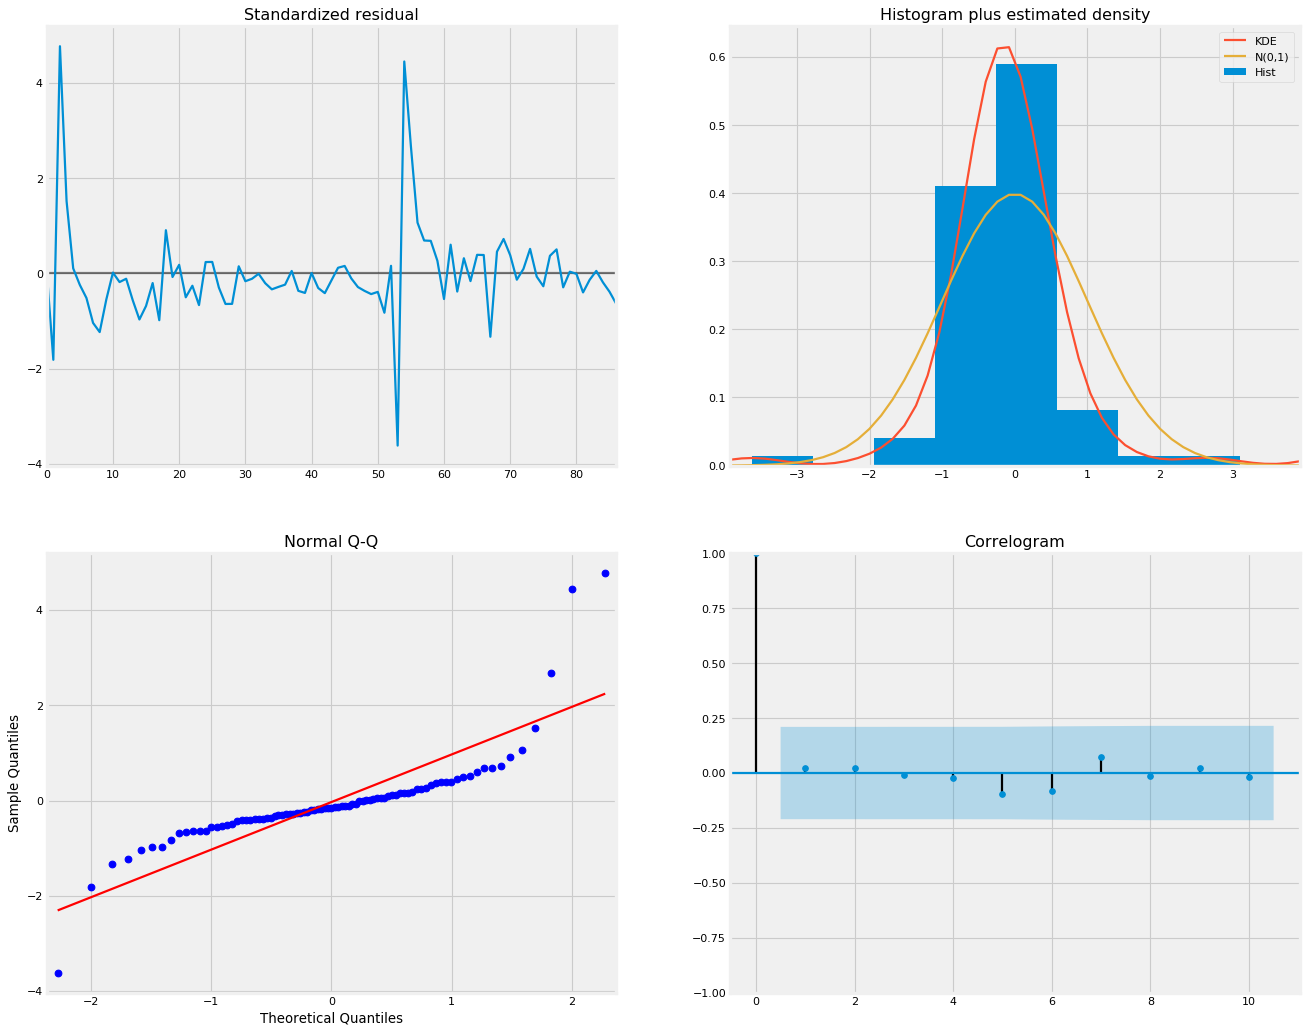

In [17]:
models['BRAND3'].plot_diagnostics()
plt.show()

Finally, when looking for the diagnostics of some models, it can be noted that, for instance the model for _BRAND3_ the distribution of the residuals follows a Gaussian distribution centered in zero, what makes sense. Besides, the correlogram shows that the model is capturing all the information of the series.

The residuals seems to have a seasonal trend. However, when computing the Dickey-Fuller test, we can note that it is almost zero, and by its correlogram and their distribution, they seem white noise and we should be satisfied.

In [18]:
print("p-value for residuals %.4g" % adfuller(models['BRAND3'].resid())[1])

p-value for residuals 1.243e-15


Thus, we are going to test the model over the different products in order to check the actual MAPE over the sales, as it is the final measure taken into account.

In [19]:
df_arima = df.dropna() # Removing rows with NaN values
df_arima = df_arima.groupby(['date', 'brand', 'sku']).sum()
df_arima

size  price  exposed      volume    sales  scope  \
date       brand  sku                                                        
2016-12-17 BRAND1 2678  105.44   1.74      0.0    3.934208  12038.0      0   
                  2681  105.44   1.73      0.0    2.999190   6175.0      0   
                  2682  105.44   1.50      0.0    1.773147   9094.0      0   
                  2683  105.44   1.74      0.0    0.948047  10192.0      0   
                  2689  395.41   1.15      1.0   17.676112  24175.0      0   
...                        ...    ...      ...         ...      ...    ...   
2019-06-22 BRAND5 2360  131.80   0.94      0.0   27.745965  10967.0      0   
                  2365  395.41   1.71      3.0  100.000000   9304.0      0   
                  2396  131.80   0.87      0.0   10.348490   6026.0      0   
                  2401  395.41   1.72      7.0  100.000000  28972.0      0   
                  2410  395.41   1.72      3.0  100.000000  12379.0      0   

                         target  variation  pack_multi  pack_single  
date       brand  sku                                                
2016-12-17 BRAND1 2678  11639.0  -0.033145         1.0          0.0  
                  2681   6103.0  -0.011660         1.0          0.0  
                  2682   8978.0  -0.012756         1.0          0.0  
                  2683   9850.0  -0.033556         1.0          0.0  
                  2689  23521.0  -0.027053         0.0          1.0  
...                         ...        ...         ...          ...  
2019-06-22 BRAND5 2360  13430.0   0.224583         0.0          1.0  
                  2365   6034.0  -0.351462         0.0          1.0  
                  2396   7949.0   0.319117         0.0          1.0  
                  2401  19356.0  -0.331907         0.0          1.0  
                  2410   8356.0  -0.324986         0.0          1.0  

[5676 rows x 10 columns]

In [20]:
for brand in df.brand.unique():
    result = pd.DataFrame(models[brand].predict(132), 
                          index=[df_arima.index.get_level_values(0).unique()], 
                          columns=['prediction'])
    result['brand'] = np.full(132, brand)
    try: 
        df_arima['prediction'].fillna(result.groupby(['date', 'brand']).sum().prediction, inplace=True)
    except:
        df_arima['prediction'] = result.groupby(['date', 'brand']).sum()

In [21]:
df_arima['forecast'] = df_arima.sales * (1 + df_arima.prediction)
df_arima.head()

size  price  exposed     volume    sales  scope  \
date       brand  sku                                                       
2016-12-17 BRAND1 2678  105.44   1.74      0.0   3.934208  12038.0      0   
                  2681  105.44   1.73      0.0   2.999190   6175.0      0   
                  2682  105.44   1.50      0.0   1.773147   9094.0      0   
                  2683  105.44   1.74      0.0   0.948047  10192.0      0   
                  2689  395.41   1.15      1.0  17.676112  24175.0      0   

                         target  variation  pack_multi  pack_single  \
date       brand  sku                                                 
2016-12-17 BRAND1 2678  11639.0  -0.033145         1.0          0.0   
                  2681   6103.0  -0.011660         1.0          0.0   
                  2682   8978.0  -0.012756         1.0          0.0   
                  2683   9850.0  -0.033556         1.0          0.0   
                  2689  23521.0  -0.027053         0.0          1.0   

                        prediction      forecast  
date       brand  sku                             
2016-12-17 BRAND1 2678    0.010819  12168.237026  
                  2681    0.010819   6241.806250  
                  2682    0.010819   9192.386402  
                  2683    0.010819  10302.265473  
                  2689    0.010819  24436.545115

In [22]:
mean_absolute_percentage_error(df_arima.target, df_arima.forecast)

16.293494721292305

Thus, the overall MAPE error for the ARIMA model is <span style="border: 1px solid green; padding: 0px 5px; border-radius: 10px; margin: 0px 3px;"> 16.2935 </span>, so we should be satisfied. In the next plot, the forecast for several SKUs of different models is represented, and as it can be noticed, at first sight, the worst model is the model for _Brand4._

In [23]:
df[df.sku.isin([2689, 1027, 1554, 1051, 2360])].groupby(['sku', 'brand']).mean().sort_values('brand')

,,size,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single
sku,brand,,,,,,,,,,
2689,BRAND1,395.41,1.114394,2.242424,38.492718,16411.719697,0,16332.378788,0.009072,0.0,1.0
1027,BRAND2,114.23,0.487576,6.560606,50.590094,88432.234848,1,88524.500000,0.060573,0.0,1.0
1554,BRAND3,395.41,1.034167,0.015152,4.424651,38992.545455,0,39125.742424,0.010045,0.0,1.0
1051,BRAND4,125.65,2.720076,11.075758,60.231542,25029.250000,1,24815.393939,0.221817,1.0,0.0
2360,BRAND5,131.80,0.929318,0.121212,36.437286,5697.977273,0,5781.295455,0.057447,0.0,1.0


In [24]:
def get_sku_plot_data(sku):
    data = df_arima.reset_index()[df_arima.reset_index().sku==sku][['target', 'forecast', 'date']]
    return data['date'], data['target'], data['forecast']

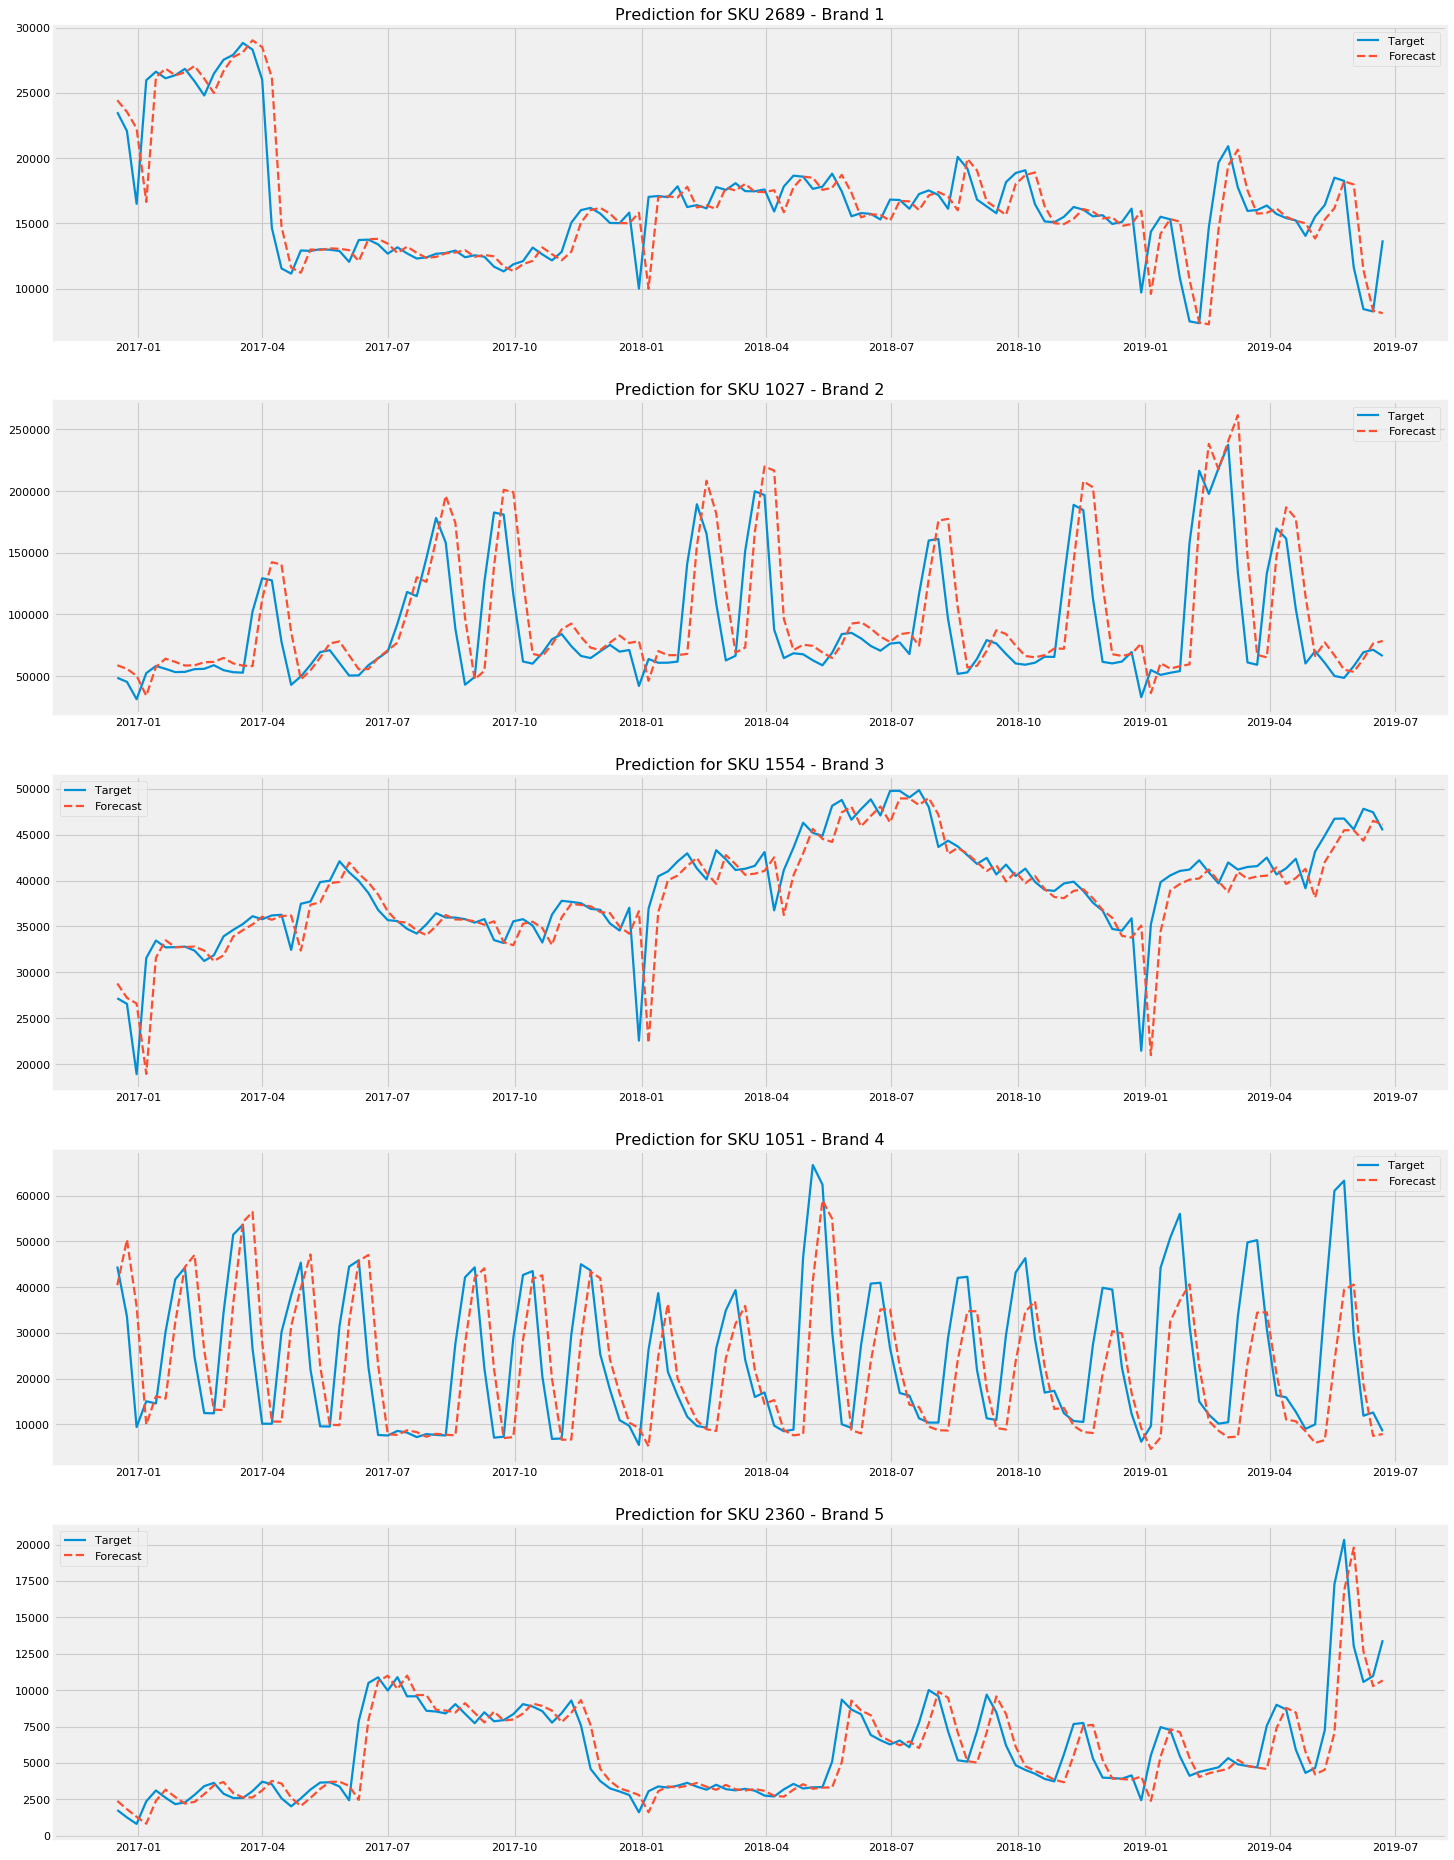

In [25]:
f, axes = plt.subplots(5, 1, figsize=(20, 30))

plt.subplot(5,1,1)
x, y1, y2 = get_sku_plot_data(2689)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 2689 - Brand 1')
plt.legend()
plt.subplot(5,1,2)
x, y1, y2 = get_sku_plot_data(1027)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 1027 - Brand 2')
plt.legend()
plt.subplot(5,1,3)
x, y1, y2 = get_sku_plot_data(1554)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 1554 - Brand 3')
plt.legend()
plt.subplot(5,1,4)
x, y1, y2 = get_sku_plot_data(1051)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 1051 - Brand 4')
plt.legend()
plt.subplot(5,1,5)
x, y1, y2 = get_sku_plot_data(2360)
plt.plot(x, y1, label="Target")
plt.plot(x, y2, '--', label="Forecast")
plt.title('Prediction for SKU 2360 - Brand 5')
plt.legend()

---

## 2.2 Linear Regression

In this section we are going to evaluate several approaches using Linear Regression and optimizing it, taking into account the overfitting and other measures. For evaluating the model, we are going to use the MAPE definition and cross-validation with a k-fold of 10.

In [26]:
import datetime as dt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

In [27]:
df_lr = df.copy()
df_lr.head()

,sku,size,brand,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single
date,,,,,,,,,,,,
2016-12-17,2689,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0,-0.027053,0.0,1.0
2016-12-24,2689,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0,-0.061477,0.0,1.0
2016-12-31,2689,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0,-0.252911,0.0,1.0
2017-01-07,2689,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0,0.574764,0.0,1.0
2017-01-14,2689,395.41,BRAND1,1.16,0.0,29.058565,25971.0,0,26627.0,0.025259,0.0,1.0


In [28]:
X_features = ['size', 'price', 'exposed', 'volume', 'sales', 'pack_multi', 'pack_single']
y_feature = 'target'

X = df_lr[X_features]
y = df_lr[y_feature]

At first, let's take polynomial attributes over the feature _sales_ in order to evaluate the MAPE metric over the different degrees. 

In [29]:
lr_model = LinearRegression()

In [30]:
def apply_polynomial_features(regressor, X, y, max_degree=10):
    mape_values, max_coefficients = [], []
    
    for degree in range(1, max_degree + 1):
        polynomial = PolynomialFeatures(degree=degree, include_bias=False)
        X_polynomial = polynomial.fit_transform(X)

        score = np.abs(cross_val_score(regressor, X_polynomial, y, cv=cv, scoring=scorer))
        mape_values.append(score)

        regressor.fit(X_polynomial, y)

        max_coefficients.append(np.amax(np.abs(regressor.coef_)))
        
    mape = pd.Series(mape_values, index=range(1,max_degree+1))
    max_coefficients = pd.Series(max_coefficients, index=range(1,max_degree+1))
    
    return mape, max_coefficients, regressor.coef_

In [31]:
max_polynomial_degree = 20
mape, coef, weights = apply_polynomial_features(lr_model, df_lr[['sales']], y, 
                                                max_degree=max_polynomial_degree)

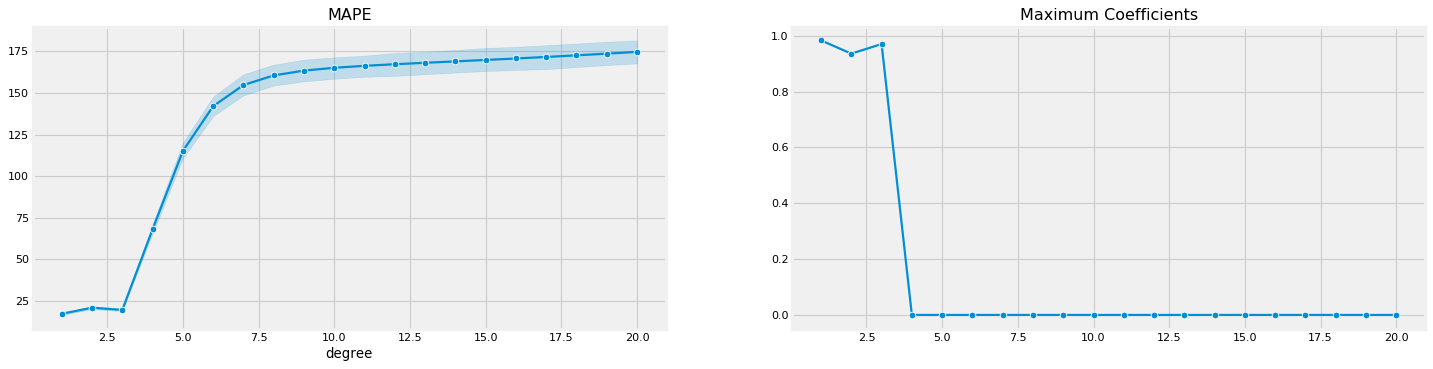

In [32]:
f, axes = plt.subplots(1, 2, figsize=(20, 5))

data = pd.DataFrame([m for m in mape], index=mape.index).T.melt(var_name='degree', value_name='')
sns.lineplot(x='degree', y='', 
             data=data, marker='o', ax=axes[0]).set_title('MAPE')
sns.lineplot(x=np.arange(1, max_polynomial_degree + 1), 
             y=coef, marker='o', ax=axes[1]).set_title('Maximum Coefficients')
plt.show()

As it can be noticed, taking polynomial features over the _sales_ feature does not improve the model. It makes it even worse, and the best performance is for degree one, which is the base model (17.0921). As we are dealing with a data series, we can shift the feature _sales_ in order to take into account past values to predict.

In [33]:
def lag_dataframe(df, num_lags):
    acc = pd.DataFrame()
    for sku in df.sku.unique():
        aux = df[df.sku == sku].iloc[:]
        for lag in range(1, num_lags + 1):
            aux['sales-{}'.format(lag)] = aux.target.shift(lag)
        acc = acc.append(aux)
            
    return acc

def lag_dataframe_volume(df, num_lags):
    acc = pd.DataFrame()
    for sku in df.sku.unique():
        aux = df[df.sku == sku].iloc[:]
        for lag in range(1, num_lags):
            aux['volume-{}'.format(lag + 1)] = aux.volume.shift(lag)
        acc = acc.append(aux)
            
    return acc

def lag_dataframe_exposed(df, num_lags):
    acc = pd.DataFrame()
    for sku in df.sku.unique():
        aux = df[df.sku == sku].iloc[:]
        for lag in range(1, num_lags):
            aux['exposed-{}'.format(lag + 1)] = aux.exposed.shift(lag)
        acc = acc.append(aux)
            
    return acc

In [34]:
df_shift = lag_dataframe(df_lr[['sku', 'target']], 10)
df_shift = df_shift.dropna()
df_shift.head()

,sku,target,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10
date,,,,,,,,,,,,
2017-02-25,2689,26476.0,24802.0,25891.0,26844.0,26358.0,26122.0,26627.0,25971.0,16492.0,22075.0,23521.0
2017-03-04,2689,27541.0,26476.0,24802.0,25891.0,26844.0,26358.0,26122.0,26627.0,25971.0,16492.0,22075.0
2017-03-11,2689,27921.0,27541.0,26476.0,24802.0,25891.0,26844.0,26358.0,26122.0,26627.0,25971.0,16492.0
2017-03-18,2689,28831.0,27921.0,27541.0,26476.0,24802.0,25891.0,26844.0,26358.0,26122.0,26627.0,25971.0
2017-03-25,2689,28318.0,28831.0,27921.0,27541.0,26476.0,24802.0,25891.0,26844.0,26358.0,26122.0,26627.0


In [35]:
lr_model = LinearRegression()

X = df_shift[df_shift.columns.difference(['sku', 'target'])]
y = df_shift.target

In [36]:
scores = np.abs(cross_val_score(lr_model, X, y, cv=cv, scoring=scorer))
print("MAPE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE: 14.0692 (+/- 2.3075)


As we can noticed, the mean MAPE has decreased by taking into account past values. However, we may do not need all that past values in order to improve the regressor. We can use Ridge and Lasso Regression to see which are the past values that most influenced the prediction.

In [37]:
ridge = Ridge(max_iter=1000, random_state=42)
scores = np.abs(cross_val_score(ridge, X, y, cv=cv, scoring=scorer))
ridge.fit(X, y)

print("MAPE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE: 14.0692 (+/- 2.3075)


In [38]:
lasso = Lasso(alpha=0.1, max_iter=1000, random_state=42)
scores = np.abs(cross_val_score(lasso, X, y, cv=cv, scoring=scorer))
lasso.fit(X, y)

print("MAPE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE: 14.0695 (+/- 2.3076)


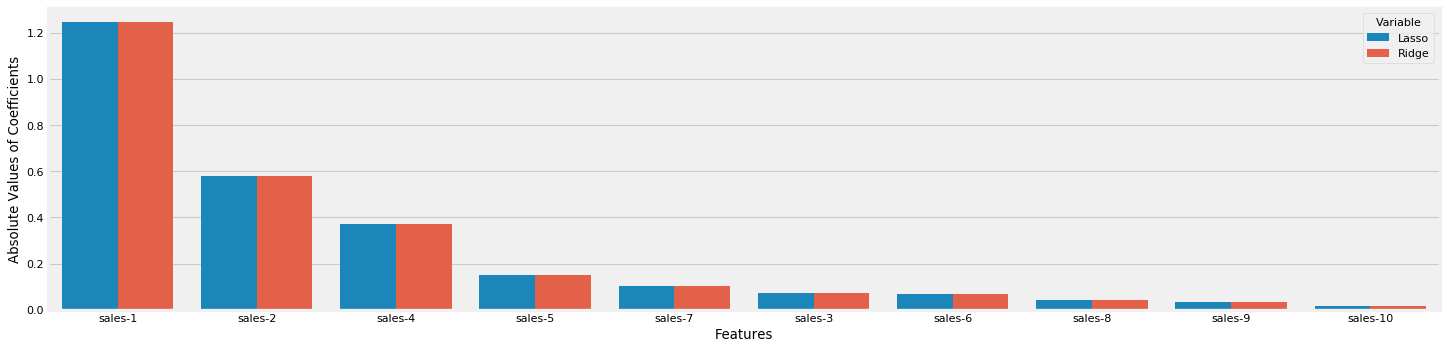

In [39]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))

coefficients = pd.DataFrame({'Features': X.columns, 
                             'Lasso':np.abs(lasso.coef_), 
                             'Ridge':np.abs(ridge.coef_)})
tidy = coefficients.sort_values('Lasso', ascending=False).melt(id_vars='Features').rename(columns=str.title)
sns.barplot(x='Features', y='Value', hue='Variable', data=tidy)
plt.ylabel("Absolute Values of Coefficients");
plt.show()

As we can noticed from the absolute values of coefficients plotted, the lags that more influence in the predictors are the sales from the 4 previous week. We also tried to lags the exposed and the volume features as they are also from the previous week, but not improvement was found. Thus, we can use them as features. 

In [40]:
df_lr_shift = lag_dataframe(df_lr, 4).dropna().drop('sales', axis=1)
df_lr_shift.head()

,sku,size,brand,price,exposed,volume,scope,target,variation,pack_multi,pack_single,sales-1,sales-2,sales-3,sales-4
date,,,,,,,,,,,,,,,
2017-01-14,2689,395.41,BRAND1,1.16,0.0,29.058565,0,26627.0,0.025259,0.0,1.0,25971.0,16492.0,22075.0,23521.0
2017-01-21,2689,395.41,BRAND1,1.16,1.0,41.877418,0,26122.0,-0.018966,0.0,1.0,26627.0,25971.0,16492.0,22075.0
2017-01-28,2689,395.41,BRAND1,1.16,0.0,22.448511,0,26358.0,0.009035,0.0,1.0,26122.0,26627.0,25971.0,16492.0
2017-02-04,2689,395.41,BRAND1,1.16,0.0,22.165187,0,26844.0,0.018438,0.0,1.0,26358.0,26122.0,26627.0,25971.0
2017-02-11,2689,395.41,BRAND1,1.16,0.0,22.744747,0,25891.0,-0.035501,0.0,1.0,26844.0,26358.0,26122.0,26627.0


In [41]:
X_features = ['sales-1', 'sales-2', 'sales-3', 'sales-4']
y_feature = 'target'

X = df_lr_shift[X_features]
y = df_lr_shift[y_feature]

In [42]:
ridge = Ridge(max_iter=1000, random_state=42)
scores = np.abs(cross_val_score(ridge, X, y, cv=cv, scoring=scorer))
print("MAPE Ridge: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

lasso = Lasso(alpha=0.1, max_iter=1000, random_state=42)
scores = np.abs(cross_val_score(lasso, X, y, cv=cv, scoring=scorer))
print("MAPE Lasso: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE Ridge: 13.9107 (+/- 2.0923)
MAPE Lasso: 13.9107 (+/- 2.0923)


Hence, our best MAPE performance is <span style="border: 1px solid green; padding: 0px 5px; border-radius: 10px; margin: 0px 3px;"> 13.9107 </span> for Lasso or Ridge, which improves our base regressor. Finally, we can plot the result after training the model over the first years and testing it over the following year. Thus, in the next plot, the left size corresponds to the model over the train set and the right one to the model over the test set.

In [43]:
lasso.fit(X['2017':'2018'], y['2017':'2018'])
df_lr_shift['forecast'] = lasso.predict(X)

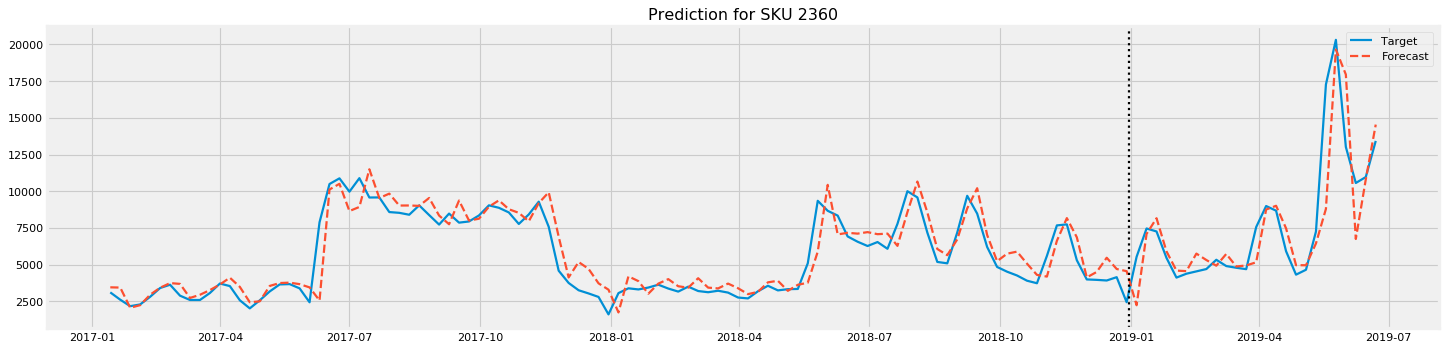

In [44]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(df_lr_shift.index.get_level_values(0).unique(), 
         df_lr_shift[df_lr_shift.sku==2360].target, label="Target")
plt.plot(df_lr_shift.index.get_level_values(0).unique(), 
         df_lr_shift[df_lr_shift.sku==2360].forecast, '--', label="Forecast")
plt.axvline(dt.datetime(2018, 12, 31), c='black', linestyle=':')
plt.title('Prediction for SKU 2360')
plt.legend()

---
## 2.3 kNN Regressor

In this section we are going to evaluate several approaches using kNearestNeighbors and optimizing it. For evaluating the model, we are going to use the MAPE definition and cross-validation with a k-fold of 10.

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [46]:
df_knn = df_lr_shift.drop('forecast', axis=1).copy()
df_knn.head()

,sku,size,brand,price,exposed,volume,scope,target,variation,pack_multi,pack_single,sales-1,sales-2,sales-3,sales-4
date,,,,,,,,,,,,,,,
2017-01-14,2689,395.41,BRAND1,1.16,0.0,29.058565,0,26627.0,0.025259,0.0,1.0,25971.0,16492.0,22075.0,23521.0
2017-01-21,2689,395.41,BRAND1,1.16,1.0,41.877418,0,26122.0,-0.018966,0.0,1.0,26627.0,25971.0,16492.0,22075.0
2017-01-28,2689,395.41,BRAND1,1.16,0.0,22.448511,0,26358.0,0.009035,0.0,1.0,26122.0,26627.0,25971.0,16492.0
2017-02-04,2689,395.41,BRAND1,1.16,0.0,22.165187,0,26844.0,0.018438,0.0,1.0,26358.0,26122.0,26627.0,25971.0
2017-02-11,2689,395.41,BRAND1,1.16,0.0,22.744747,0,25891.0,-0.035501,0.0,1.0,26844.0,26358.0,26122.0,26627.0


In [47]:
X_features = ['size', 'price', 'exposed', 'volume', 'pack_multi', 
              'pack_single', 'sales-1', 'sales-2', 'sales-3', 'sales-4']

X = df_knn[X_features]
y = df_knn.target

In [48]:
knn_model = KNeighborsRegressor()

In [49]:
scores = np.abs(cross_val_score(knn_model, X, y, cv=cv, scoring=scorer))
print("MAPE kNN: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE kNN: 13.5372 (+/- 1.9856)


A simple kNN Regressor results in a better performance. Besides, the standard deviation is lower than in the previous case, that means that the MAPE difference between the predictions is lower. Let's optimize the hyperparameters such as the number of neighbors and weights of the alorithm.

In [50]:
param_grid = {
    'n_neighbors': np.linspace(5,500,10).astype(int),
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': np.arange(10, 60, 10),
    'p': [1, 2] # Euclidean distance por p=2 and Manhattan distance for p=1
}
gs = GridSearchCV(knn_model, param_grid, cv=cv, scoring=scorer, n_jobs=-1)

In [51]:
gs.fit(X, y)
print("Best MAPE score found %0.4f" % np.abs(gs.best_score_))

Best MAPE score found 13.2159


In [52]:
gs.best_estimator_

KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                    weights='distance')

In [53]:
knn_model = KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
                                metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                                weights='distance')

Thus, as it can be noticed, the best estimator using kNN Regressor is by using the _ball tree_ algorithm with a leaf size of 10 and 5 neighbors using the Manhattan distance.

However, the features are not standarized, so they might behave feadly if the individual features do not more or less look loke standard normally distributed data: Gaussian with zero mean and unit variance, as it can be noticed in the table below. 

In [54]:
X.describe()

,size,price,exposed,volume,pack_multi,pack_single,sales-1,sales-2,sales-3,sales-4
count,5504.000000,5504.000000,5504.000000,5504.000000,5504.000000,5504.000000,5504.000000,5504.000000,5504.000000,5504.000000
mean,245.581860,1.192128,2.937500,31.488314,0.255814,0.744186,51329.894077,51174.490734,51104.136628,51049.204215
std,192.704819,0.700954,8.522277,36.631518,0.436357,0.436357,95231.592564,95049.607469,94897.462554,94745.752088
min,87.870000,0.300000,0.000000,0.000000,0.000000,0.000000,1561.000000,813.000000,813.000000,813.000000
25%,114.230000,0.560000,0.000000,0.904414,0.000000,0.000000,12582.500000,12549.000000,12549.000000,12540.500000
50%,131.800000,1.080000,0.000000,18.784355,0.000000,1.000000,22185.000000,22122.500000,22122.500000,22122.500000
75%,395.410000,1.610000,2.000000,43.821834,1.000000,1.000000,46891.750000,46595.000000,46472.250000,46452.250000
max,878.680000,3.890000,70.000000,100.066205,1.000000,1.000000,714202.000000,714202.000000,714202.000000,714202.000000


For this reason, we are going to use the Standard Scaler in order to standarize them by removing the mean and scaling to unit the variance. This will perform the following transformation over the features.

$ x' = \frac{x - \mu}{\sigma} $, where $\mu$ is the mean of the training samples and $\sigma$ is the standard deviation of the training samples.

In [55]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn_model)
])

In [56]:
scores = np.abs(cross_val_score(pipe, X, y, cv=cv, scoring=scorer))
print("MAPE kNN: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE kNN: 11.1418 (+/- 2.0863)


We have tested by only standarizing some features such as _price_ and _size._ However, the best performance has been found for standaring the whole matrix X. Thus, our MAPE achieved so far is <span style="border: 1px solid green; padding: 0px 5px; border-radius: 10px; margin: 0px 3px;"> 11.1418 </span>. 

In [57]:
pipe.fit(X['2017':'2018'], y['2017':'2018'])
df_knn['forecast'] = pipe.predict(X)

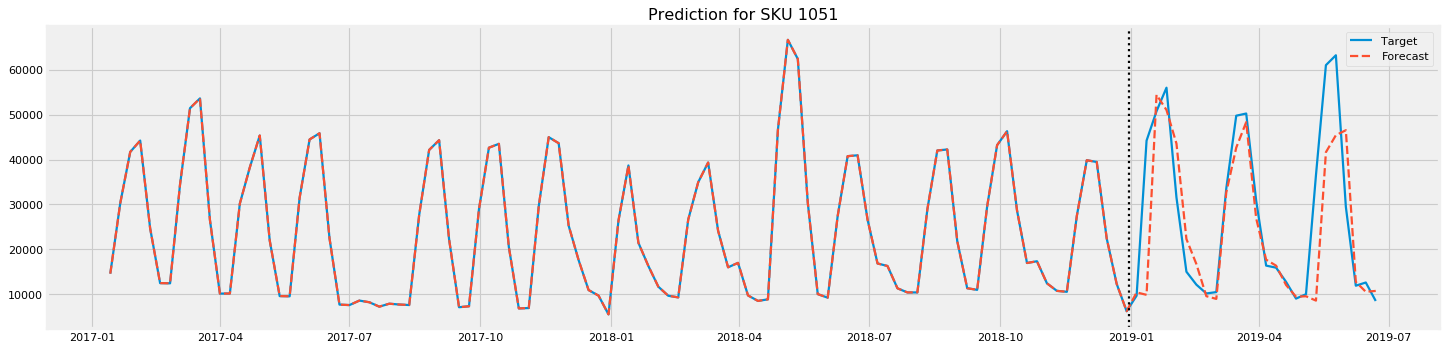

In [58]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(df_knn.index.get_level_values(0).unique(), 
         df_knn[df_knn.sku==1051].target, label="Target")
plt.plot(df_knn.index.get_level_values(0).unique(), 
         df_knn[df_knn.sku==1051].forecast, '--', label="Forecast")
plt.axvline(dt.datetime(2018, 12, 31), c='black', linestyle=':')
plt.title('Prediction for SKU 1051')
plt.legend()

However, as it can be noticed, in the plot below, the prediction over the test set is not as good as the one above. The difference between both SKU is that they belongs to different brands. Thus, a possible option is to fit different regressors for each brand as it was done in the data series since SKUs within a brand have similar weekly sales variation behavior. We will come back to this approach later.

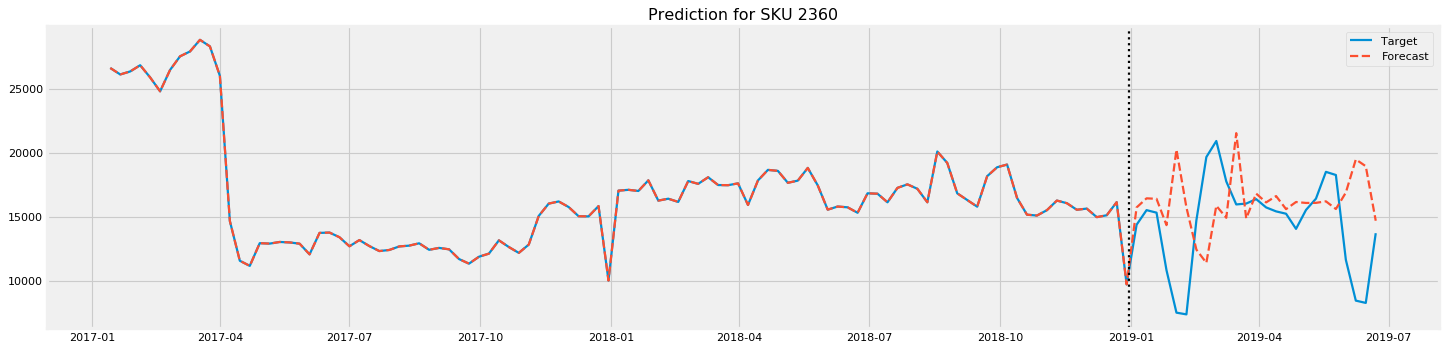

In [59]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(df_knn.index.get_level_values(0).unique(), 
         df_knn[df_knn.sku==2689].target, label="Target")
plt.plot(df_knn.index.get_level_values(0).unique(), 
         df_knn[df_knn.sku==2689].forecast, '--', label="Forecast")
plt.axvline(dt.datetime(2018, 12, 31), c='black', linestyle=':')
plt.title('Prediction for SKU 2360')
plt.legend()

---
## 2.4 Random Forest Regressor

In this section, a Random Forest Regressor is tested. It is an estimator that fits a number of classifying decision trees and uses averaging to improve the predictive accuracy and control over-fitting.

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [61]:
df_rfr = df_lr.copy()
df_rfr.head()

,sku,size,brand,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single
date,,,,,,,,,,,,
2016-12-17,2689,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0,-0.027053,0.0,1.0
2016-12-24,2689,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0,-0.061477,0.0,1.0
2016-12-31,2689,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0,-0.252911,0.0,1.0
2017-01-07,2689,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0,0.574764,0.0,1.0
2017-01-14,2689,395.41,BRAND1,1.16,0.0,29.058565,25971.0,0,26627.0,0.025259,0.0,1.0


In [62]:
X_features = ['size', 'price', 'exposed', 'volume', 'pack_multi', 
              'pack_single', 'sales-1', 'sales-2', 'sales-3', 'sales-4']

X = df_rfr[df_rfr.columns[df_rfr.columns.isin(X_features)]]
y = df_rfr.target

In [63]:
rfr_model = RandomForestRegressor(random_state=42)

In [64]:
scores = np.abs(cross_val_score(rfr_model, X, y, cv=cv, scoring=scorer))
print("MAPE Random Forest: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE Random Forest: 28.5182 (+/- 2.7875)


As we can noticed, the MAPE error for the Random Forest Regressor is really bad at performance compared with the previous models. Let's evaluate the model taking into account the number of lags.

In [65]:
def compare_lags_rfr(df, lags):
    mape_error = []
    for i in range(1, lags+1):
        df = lag_dataframe(df_rfr, num_lags=i).dropna()
        
        X_shift = df[df.columns.difference(['sku', 'brand', 'target', 'variation', 'sales', 'scope'])]
        y_shift = df.target

        mape_error.append(np.abs(cross_val_score(rfr_model, X_shift, y_shift, cv=cv, scoring=scorer)))
    
    return pd.Series(mape_error, index=range(1, lags+1))

In [66]:
mape = compare_lags_rfr(df_rfr, 10)

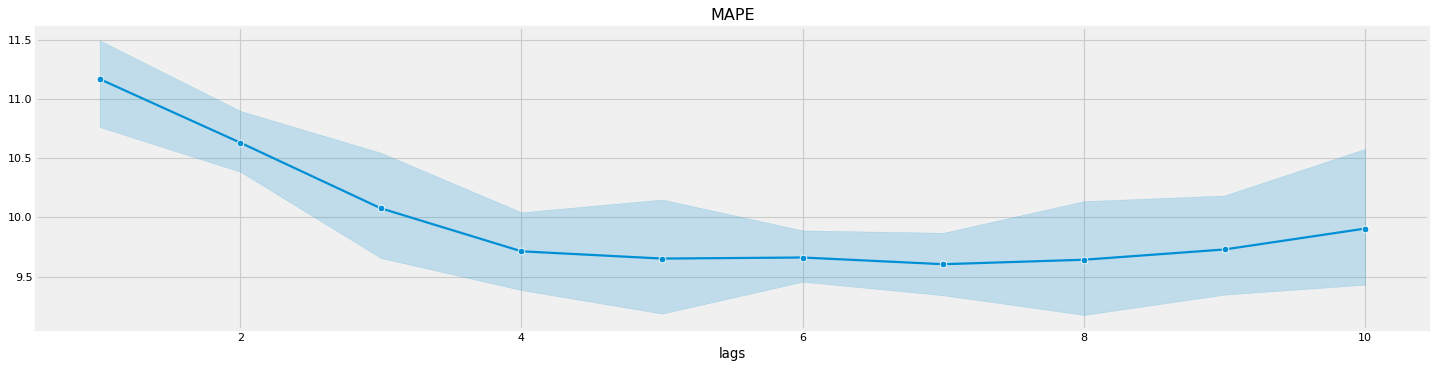

In [67]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))

data = pd.DataFrame([m for m in mape], index=mape.index).T.melt(var_name='lags', value_name='')
sns.lineplot(x='lags', y='', 
             data=data, marker='o').set_title('MAPE')
plt.show()

As it can be noticed, the best performance regarding the MAPE error measure is for 5 lags. Thus, we are going to use 5 lags for the Random Forest Regressor. The next approach will be computing the best number of estimators doing a Grid Search.

In [68]:
df_rfr_shift = lag_dataframe(df_rfr, num_lags=5).dropna()
df_rfr_shift.head()

,sku,size,brand,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single,sales-1,sales-2,sales-3,sales-4,sales-5
date,,,,,,,,,,,,,,,,,
2017-01-21,2689,395.41,BRAND1,1.16,1.0,41.877418,26627.0,0,26122.0,-0.018966,0.0,1.0,26627.0,25971.0,16492.0,22075.0,23521.0
2017-01-28,2689,395.41,BRAND1,1.16,0.0,22.448511,26122.0,0,26358.0,0.009035,0.0,1.0,26122.0,26627.0,25971.0,16492.0,22075.0
2017-02-04,2689,395.41,BRAND1,1.16,0.0,22.165187,26358.0,0,26844.0,0.018438,0.0,1.0,26358.0,26122.0,26627.0,25971.0,16492.0
2017-02-11,2689,395.41,BRAND1,1.16,0.0,22.744747,26844.0,0,25891.0,-0.035501,0.0,1.0,26844.0,26358.0,26122.0,26627.0,25971.0
2017-02-18,2689,395.41,BRAND1,1.16,2.0,23.543316,25891.0,0,24802.0,-0.042061,0.0,1.0,25891.0,26844.0,26358.0,26122.0,26627.0


In [69]:
X = df_rfr_shift[df_rfr_shift.columns.difference(['sku', 'brand', 'target', 'variation', 'sales', 'scope'])]
y = df_rfr_shift.target

In [70]:
param_grid = {
    'n_estimators': np.linspace(5,500,10).astype(int),
}
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=cv, scoring=scorer, n_jobs=-1)

In [71]:
gs.fit(X, y)
print("Best MAPE score found %0.4f" % np.abs(gs.best_score_))

Best MAPE score found 9.5988


In [72]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=280, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Thus, we have have evaluated the models for different numbers of estimators and the best one found is the model above with 280 estimators and a MAPE error of about <span style="border: 1px solid green; padding: 0px 5px; border-radius: 10px; margin: 0px 3px;"> 9.5988 </span>. Finally, we can plot the results after fitting the model with data from 2017 and 2018 and predicting over the whole dataset

In [73]:
rfr_model = RandomForestRegressor(n_estimators=280, random_state=42)

In [74]:
scores = np.abs(cross_val_score(rfr_model, X, y, cv=cv, scoring=scorer))
print("MAPE Random Forest: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE Random Forest: 9.5988 (+/- 1.5247)


In [75]:
rfr_model.fit(X['2017':'2018'], y['2017':'2018'])
df_rfr_shift['forecast'] = rfr_model.predict(X)

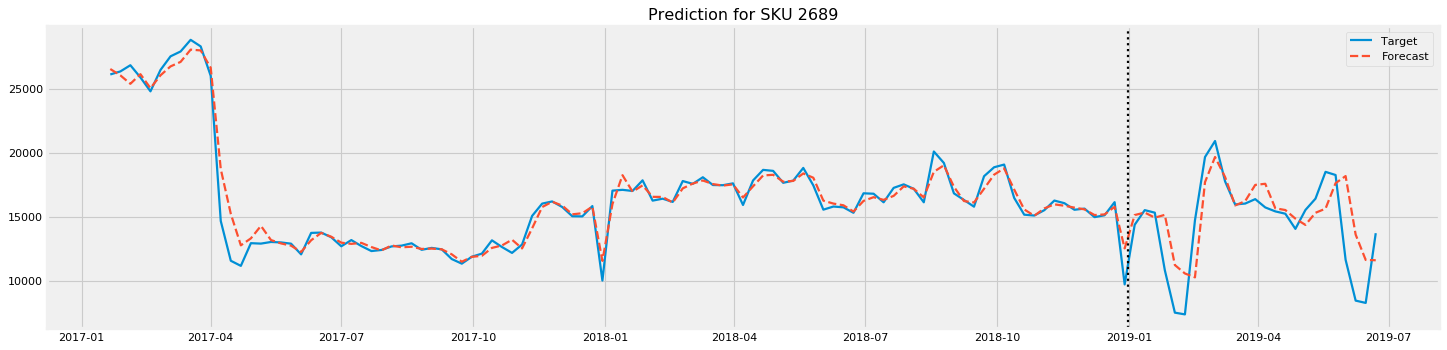

In [76]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(df_rfr_shift.index.get_level_values(0).unique(), 
         df_rfr_shift[df_rfr_shift.sku==2689].target, label="Target")
plt.plot(df_rfr_shift.index.get_level_values(0).unique(), 
         df_rfr_shift[df_rfr_shift.sku==2689].forecast, '--', label="Forecast")
plt.axvline(dt.datetime(2018, 12, 31), c='black', linestyle=':')
plt.title('Prediction for SKU 2689') 
plt.legend()

---
## 2.5 Brand Exploration

As we did on the [Data Series section](#2.2-ARMA-Model), we know that SKUs within the same brands have similar behaviors on the variation of the weekly sales. We could think of using different models for each SKU, but this is too costly. However, we have 5 different brands and we can fit different predictors for each one.

Thus, we are going to take the best predictors from the previous sections in order to test them over one brand, instead of over the whole dataset.

In [77]:
arima_models = models # ARIMA models fitted for each brand
lr_model     = Lasso(alpha=0.1, max_iter=1000, random_state=42) # Linear Regression model
knn_model    = Pipeline([
                    ('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor(algorithm='ball_tree', leaf_size=10, metric='minkowski',
                                                n_neighbors=5, p=1, weights='distance'))
               ])
rfr_model    = RandomForestRegressor(n_estimators=280, random_state=42)

In [78]:
df_m = lag_dataframe(df, 4).dropna()
df_m.head()

,sku,size,brand,price,exposed,volume,sales,scope,target,variation,pack_multi,pack_single,sales-1,sales-2,sales-3,sales-4
date,,,,,,,,,,,,,,,,
2017-01-14,2689,395.41,BRAND1,1.16,0.0,29.058565,25971.0,0,26627.0,0.025259,0.0,1.0,25971.0,16492.0,22075.0,23521.0
2017-01-21,2689,395.41,BRAND1,1.16,1.0,41.877418,26627.0,0,26122.0,-0.018966,0.0,1.0,26627.0,25971.0,16492.0,22075.0
2017-01-28,2689,395.41,BRAND1,1.16,0.0,22.448511,26122.0,0,26358.0,0.009035,0.0,1.0,26122.0,26627.0,25971.0,16492.0
2017-02-04,2689,395.41,BRAND1,1.16,0.0,22.165187,26358.0,0,26844.0,0.018438,0.0,1.0,26358.0,26122.0,26627.0,25971.0
2017-02-11,2689,395.41,BRAND1,1.16,0.0,22.744747,26844.0,0,25891.0,-0.035501,0.0,1.0,26844.0,26358.0,26122.0,26627.0


In [79]:
no_features = ['sku', 'brand', 'target', 'variation', 'sales', 'scope']
results = {}

for brand in df_m.brand.unique():
    print('Computing metrics for brand {}'.format(brand))    
    X_brand = df_m[df_m.brand == brand][df_m.columns.difference(no_features)]
    y_brand = df_m[df_m.brand == brand].target
        
    result = {
           'LinearRegression': np.abs(cross_val_score(lr_model,  X_brand, y_brand, cv=cv, scoring=scorer)).mean(),
          'kNearestNeighbors': np.abs(cross_val_score(knn_model, X_brand, y_brand, cv=cv, scoring=scorer)).mean(),
      'RandomForestRegressor': np.abs(cross_val_score(rfr_model, X_brand, y_brand, cv=cv, scoring=scorer)).mean()
    }
    results[brand] = (result)

Computing metrics for brand BRAND1
Computing metrics for brand BRAND2
Computing metrics for brand BRAND3
Computing metrics for brand BRAND4
Computing metrics for brand BRAND5


Let's add the ARIMA models MAPE measures to the results.

In [80]:
for brand in df_m.brand.unique():
    aux = df_m[df_m.brand == brand].copy()
    prediction = pd.DataFrame(arima_models[brand].predict(132), 
                              index=[df_arima.index.get_level_values(0).unique()], 
                              columns=['prediction'])
    aux['prediction'] = prediction.groupby(['date']).sum()
    aux['forecast'] = aux.sales * (1 + aux.prediction)
    results[brand]['ARIMA'] = mean_absolute_percentage_error(aux.target, aux.forecast)

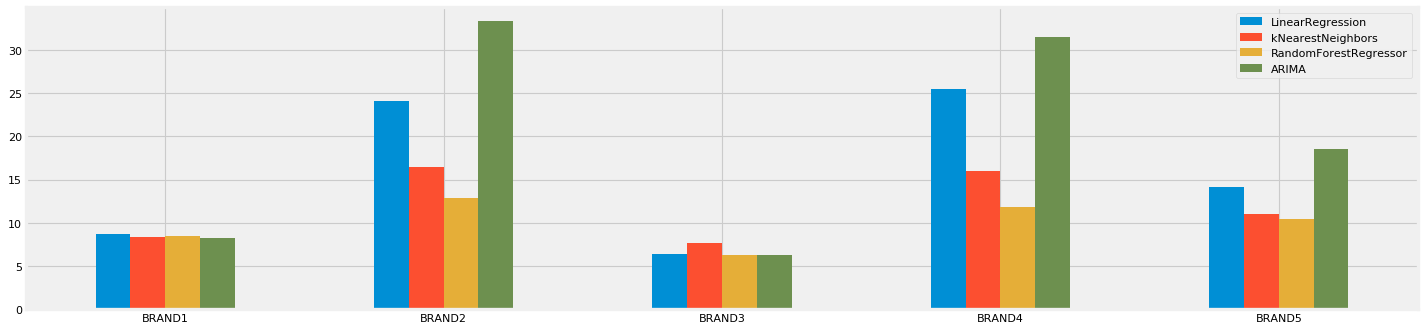

In [81]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))
pd.DataFrame(results).T.plot.bar(ax=axes, rot=0)
plt.show()

In [82]:
pd.DataFrame(results).T

,LinearRegression,kNearestNeighbors,RandomForestRegressor,ARIMA
BRAND1,8.739749,8.307205,8.429953,8.234664
BRAND2,24.077841,16.498490,12.845648,33.306490
BRAND3,6.401181,7.656202,6.300421,6.273029
BRAND4,25.464589,15.970466,11.858924,31.516941
BRAND5,14.095053,10.983209,10.380662,18.556977


As we can noticed, the brands with worst performance are the _BRAND2_ and _BRAND4_. We could try to improve the performance of the algorithms over those brands. Leaving this aside, the model with best performance over the five brands is the Random Forest Regressor.